In [ ]:
import pickle
import json
import funcy
import csv
import os
import gzip
import pandas as pd
import numpy as np
import imblearn

import sklearn
# from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import svm
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline
import scipy

import imblearn
from imblearn.under_sampling import RandomUnderSampler
# #from imblearn.pipeline import make_pipeline as make_pipeline_imb
# from imblearn.metrics import classification_report_imbalanced

import matplotlib.pyplot as plt 

In [ ]:
v6 = pd.read_pickle(
    '/pool001/lraymond/processed_data/pre_analysis_dfs/standardized_linear_classifier_df.p')

In [ ]:
v6['10_year_cites_top1'].describe()

In [ ]:
print(v6.shape)

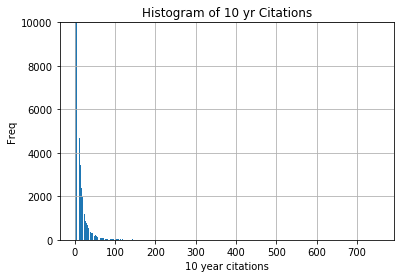

In [13]:
# plotting distrubution information
v6['10_year_cites'].hist(bins=1000)
plt.xlabel('10 year citations')
plt.ylabel('Freq')
plt.title('Histogram of 10 yr Citations')
plt.grid(True)
plt.ylim(0, 10000)

plt.show()

color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange',
             'medians': 'DarkBlue', 'caps': 'Gray'}
v6['10_year_cites'].plot.box(vert=False, color=color)
plt.title('Details on Max/Min of 10 yr Citations')
plt.show()

In [28]:
descr = v6['10_year_cites'].describe(percentiles=[.25, .5, .75, .85, .9])

print(descr)

# create a couple other classification categories to run the SVM on
v6['10_year_cites_top10'] = (v6['10_year_cites']>= descr['90%']).astype(int)

v6['10_year_cites_top10'].describe()

# create a couple other classification categories to run the SVM on
v6['10_year_cites_top50'] = (v6['10_year_cites']>= descr['50%']).astype(int)

v6['10_year_cites_top50'].describe()

v6['10_year_cites_top75'] = (v6['10_year_cites'] >= descr['25%']).astype(int)

# note there are a lot of patents that get 2 so choice of greater than or greater than equal matters alot
v6['10_year_cites_top75'].describe()

v6['10_year_cites_above0'] = (v6['10_year_cites'] > 0).astype(int)

v6['10_year_cites_above0'].describe()

additional_margins = [ ('10_year_cites_above0', 'SVM_morethan0_vs1'),
                        ('10_year_cites_top50', 'SVM_top50vs_rest',), 
                      # ('10_year_cites_top75', 'SVM_top75vs_rest'),
                        ('10_year_cites_top10', 'SVM_top10vs_rest')
                     ]

In [39]:
print('test')

test


In [ ]:
for output_col, classifier_name in additional_margins:
    print(output_col)
    # Y_col = ['10_year_cites_top1']
    Y_col = output_col
    X_cols = [c for c in v6.columns if '_cites' not in c]

    # print(sorted(X_cols))
    rus = RandomUnderSampler(sampling_strategy=1, return_indices=True, random_state=0)
    
    
    # If I want to control to contrast group, I select on the 10 year cites values column
    # print(np.any(np.logical_and(mask_control, mask_target)))

    X = v6[X_cols].as_matrix()
    Y = v6[Y_col]

    # want y to be a 1d object 
    print(X.shape)
    print(Y.shape)
    print(v6.shape)
    print(Y.mean())
    
    # (X[ind]==X_resampled).all() should be True
    X_resampled, y_resampled, ind = rus.fit_resample(X, Y)
    print(X_resampled.shape, y_resampled.shape, y_resampled.mean())
    
    X_train, X_test, y_train, y_test, pat_nums_train, pat_nums_test = sklearn.model_selection.train_test_split(
    X_resampled, y_resampled, ind, random_state=0, shuffle=True)
    
    # added a max iter argument because things were taking a really long time to converge
    clf = svm.SVC(kernel='sigmoid', probability=True, max_iter=5000)
    
    tprs = []
    aucs = []
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    cv = sklearn.model_selection.StratifiedKFold(n_splits=8)

    for train, test in cv.split(X_resampled, y_resampled):
        print(y_resampled[train].mean())
        probas_ = clf.fit(X_resampled[train], y_resampled[train]).predict_proba(X_resampled[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_resampled[test], probas_[:, 1])
        tprs.append(scipy.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
            label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    # classifier_name = 'SVM_below25'
    print(classifier_name)
    mean_fpr = np.linspace(0, 1, 100)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {}'.format(classifier_name))
    plt.legend(loc="lower right")
    plt.savefig('/home/lraymond/plots/{}.png'.format(classifier_name))
    plt.show()
    


10_year_cites_above0
(188672, 272)
(188672,)
(188672, 278)
0.925897854477612
(27962, 272) (27962,) 0.5
0.5


In [ ]:


# # Train the classifier with balancing
# clf.fit(X_train, y_train)

# # Test the classifier and get the prediction
# y_pred_bal = clf.predict(X_test)
# y_pred = clf.predict_proba(X_test)
# y_pred_probs = y_pred[:,1]